In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import gym
from collections import deque

In [2]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

env = gym.make("CartPole-v0")

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
num_frames = 10000
batch_size = 32
gamma = 0.99

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
    -1. * frame_idx / epsilon_decay)

100 10000
200 10000
300 10000
400 10000
500 10000
600 10000
700 10000
800 10000
900 10000
1000 10000
1100 10000
1200 10000
1300 10000
1400 10000
1500 10000
1600 10000
1700 10000
1800 10000
1900 10000
2000 10000
2100 10000
2200 10000
2300 10000
2400 10000
2500 10000
2600 10000
2700 10000
2800 10000
2900 10000
3000 10000
3100 10000
3200 10000
3300 10000
3400 10000
3500 10000
3600 10000
3700 10000
3800 10000
3900 10000
4000 10000
4100 10000
4200 10000
4300 10000
4400 10000
4500 10000
4600 10000
4700 10000
4800 10000
4900 10000
5000 10000
5100 10000
5200 10000
5300 10000
5400 10000
5500 10000
5600 10000
5700 10000
5800 10000
5900 10000
6000 10000
6100 10000
6200 10000
6300 10000
6400 10000
6500 10000
6600 10000
6700 10000
6800 10000
6900 10000
7000 10000
7100 10000
7200 10000
7300 10000
7400 10000
7500 10000
7600 10000
7700 10000
7800 10000
7900 10000
8000 10000
8100 10000
8200 10000
8300 10000
8400 10000
8500 10000
8600 10000
8700 10000
8800 10000
8900 10000
9000 10000
9100 10000
9200 100

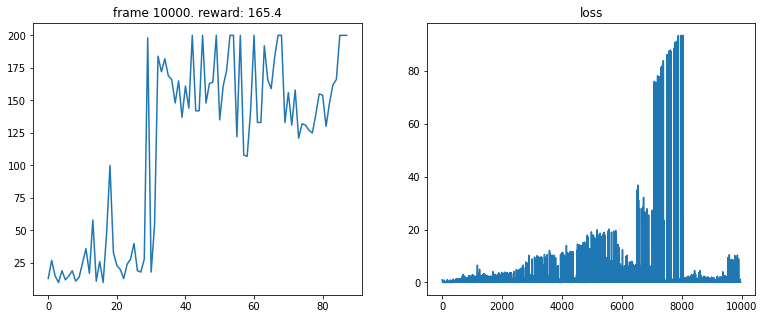

In [3]:
# Double DQN Network
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, x):
        return self.layers(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action = q_value.max(1)[1].data[0].item()
            #print(action,'-')
        else:
            action = random.randrange(env.action_space.n)
            #print(action, '*')
        return action


current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model = DQN(env.observation_space.shape[0], env.action_space.n)

optimizer = torch.optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)


def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())


update_target(current_model, target_model)


def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done = torch.FloatTensor(done)

    q_values = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - expected_q_value.data).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


def plot(frame_idx, rewards, losses):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    if frame_idx % 100 == 0:
        print(frame_idx, num_frames)
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    #print(action)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())

    # if frame_idx % 200 == 0:
    #     plot(frame_idx, all_rewards, losses)

    if frame_idx % 100 == 0:
        update_target(current_model, target_model)
    #print(losses)

plot(frame_idx, all_rewards, losses)